In [70]:
import pyro
import torch
import gpytorch
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/indian-buffet-process/data/16APR2025.h5ad")
adata = adata[adata.obs["cell_type"].eq("Microglia-PVM") & adata.obs["folder"].eq("99-15")]

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [71]:
import torch
import numpy as np
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata, specimen_name: str = "folder"):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].layers["transcript"])
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    folder = torch.tensor(pd.Categorical(adata.obs[specimen_name]).codes).float()
    return X, size_factor, folder

X, size_factor, folder = setup_torch_data(adata, specimen_name="folder")

X = X.to(device)
size_factor = size_factor.to(device)
folder = folder.to(device)
locs = torch.tensor(adata.obs[["x_centroid", "y_centroid"]].values).to(device)
group_assignments = torch.zeros(X.shape[0])

# Indian Buffet Process (Generally)

We have a bunch of latent features, denoted as z, which occur for each sample and latent feature. These latent features are supposed to be sampled through a dirichlet stick breaking process, which we sample via some beta distribution (its kinda just sugar to talk about it more). Each of these features have associated logits, which we sample via a Gamma distribution for flexibility. The logits for NB inference is then combined through (z@w)+size_factor, and we sample the events per row.


In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

def model(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape
    G = int(torch.max(group_assignments).item() + 1)

    # IBP stick-breaking beta parameters
    alpha_param = pyro.param(
        "alpha",
        dist.Gamma(torch.full((), alpha, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )
    beta_param = pyro.param(
        "beta",
        dist.Gamma(alpha_param,
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )

    with pyro.plate("ibp_features", K):
        v = pyro.sample("v", dist.Beta(alpha_param, beta_param))  # [K]

    pi = torch.cumprod(v, dim=0)

    W = pyro.sample(
        "W",
        dist.Normal(torch.full((), 0.0, device=device, dtype=dtype),
                    torch.full((), 1.0, device=device, dtype=dtype))
        .expand([K, D]).to_event(2)
    )

    # Shared dispersion across all groups
    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((D,), 2.0, device=device, dtype=dtype),
                   torch.full((D,), 1.0, device=device, dtype=dtype)).to_event(1)
    )

    # Per-group (folder) logits, shape [G, D]
    folder_logit = pyro.param(
        "folder_logit",
        torch.zeros(G, D, device=device, dtype=dtype),
    )

    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(pi).to_event(1))  # [N, K]
        logits = (z @ W) + size_factor.reshape(-1, 1)  # [N, D]

        # Add per-group logit shift
        group_logit_offset = folder_logit[group_assignments.int()]  # [N, D]
        logits = logits + group_logit_offset

        logits = torch.clamp(logits, -15, 15)
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)


def guide(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    with pyro.plate("ibp_features", K):
        qv_alpha = pyro.param("qv_alpha", torch.ones(K, device=device, dtype=dtype),
                              constraint=dist.constraints.greater_than(1e-2))
        qv_beta = pyro.param("qv_beta", torch.ones(K, device=device, dtype=dtype),
                             constraint=dist.constraints.greater_than(1e-2))
        pyro.sample("v", dist.Beta(qv_alpha, qv_beta))

    with pyro.plate("observations", N):
        qz_logits = pyro.param("qz_logits", (torch.randn(N, K, device=device, dtype=dtype) * 0.01 - 2.0))
        pyro.sample("Z", dist.RelaxedBernoulliStraightThrough(
            temperature=torch.full((), 0.5, device=device, dtype=dtype),
            logits=qz_logits
        ).to_event(1))

    qW_loc = pyro.param("qW_loc", torch.randn(K, D, device=device, dtype=dtype))
    qW_scale = pyro.param("qW_scale", torch.ones(K, D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    pyro.sample("W", dist.Normal(qW_loc, qW_scale).to_event(2))

    # Shared dispersion
    qr_alpha = pyro.param("qr_alpha", torch.ones(D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    qr_beta = pyro.param("qr_beta", torch.ones(D, device=device, dtype=dtype),
                         constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(qr_alpha, qr_beta).to_event(1))



In [4]:
import torch
import pyro
import pyro.optim
import pyro.infer
import wandb
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

# Example training loop
pyro.clear_param_store()

dtype = float
X = X.to(device=device, dtype=dtype)
size_factor = size_factor.to(device=device, dtype=dtype)
K = torch.tensor(40, device=device)  # or whatever value, as a tensor
folder = folder.to(device)

optimizer = ClippedAdam({"lr": 0.01})
elbo = JitTrace_ELBO() # Real Fn Fast
svi = SVI(model, guide, optimizer, loss=elbo)

import wandb
wandb.init(project="ibp-nb-model-choroid-plexus", name="macrophage-2-individual-dispersions", config={
    "latent_dim_K": K,
    "learning_rate": 1e-2,
    "elbo": "JitTrace_ELBO",
})

wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [35]:
for step in range(100_000):
    loss = svi.step(X.float(), K.float(), size_factor.float(), group_assignments=folder.float())
    break
    if step % 1 == 0:
        mean_logits = pyro.get_param_store()["qz_logits"].mean().item()
        percentage_logits_above_0 = (pyro.get_param_store()["qz_logits"] > 0).float().mean().item()
        
        wandb.log({
            "step": step,
            "loss": loss,
            "mean_logits": mean_logits,
            "percentage_logits_above_0": percentage_logits_above_0
        })
        
        print(f"[Step {step}] Loss: {loss:.2e}", mean_logits, percentage_logits_above_0)

# Enabling Spatial Learning using Covariance Matrices

**Lets walk step by step through this to ensure we understand how this works.**

1. We setup a gp kernel, which we intend to learn.

# Spatially Dependent Indian Buffet Process

$$
u_k == (u_{ik})_{i \in n} \sim N_n(\mu 1_n, \tau^{-1}Q(\phi))
$$



In [ ]:
tau = pyro.param("tau", torch.tensor(1.0, device=device, dtype=torch.float32), constraint=constraints.positive)
phi = pyro.param("phi", torch.tensor(1.0, device=device, dtype=torch.float32), constraint=constraints.positive)
mu = pyro.param("mu", torch.tensor(0.1, device=device, dtype=torch.float32), constraint=constraints.positive)

locs = locs.to(device=device, dtype=torch.float32)  # Ensure locs is also float32

# Define kernel and compute covariance
kernel = MaternKernel(nu=2.5).to(device)
cov_matrix = kernel(locs).evaluate()  # This will be float32
scaled_cov_matrix = (1.0 / tau) * cov_matrix

num_latents = 10

# Expand mean and cov to be batched
mean = mu * torch.ones(num_latents, locs.shape[0], device=device, dtype=torch.float32)
cov_matrix = scaled_cov_matrix.expand(num_latents, -1, -1)  # [num_latents, N, N]

latent_logits = dist.MultivariateNormal(mean, covariance_matrix=cov_matrix)

b_ik = torch.sigmoid(latent_logits.rsample()).cumprod(dim=1)


tensor([[0.4961, 0.0706, 0.0364,  ..., 0.0000, 0.0000, 0.0000],
        [0.4073, 0.3299, 0.2261,  ..., 0.0000, 0.0000, 0.0000],
        [0.2849, 0.2204, 0.1431,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7091, 0.1670, 0.0910,  ..., 0.0000, 0.0000, 0.0000],
        [0.1698, 0.0952, 0.0885,  ..., 0.0000, 0.0000, 0.0000],
        [0.1224, 0.0325, 0.0158,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<CumprodBackward0>)

# Trying to Implement the SIBP

In [4]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

def model(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape
    G = int(torch.max(group_assignments).item() + 1)

    # IBP stick-breaking beta parameters
    alpha_param = pyro.param(
        "alpha",
        dist.Gamma(torch.full((), alpha, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )
    beta_param = pyro.param(
        "beta",
        dist.Gamma(alpha_param,
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )

    with pyro.plate("ibp_features", K):
        v = pyro.sample("v", dist.Beta(alpha_param, beta_param))  # [K]

    pi = torch.cumprod(v, dim=0)

    W = pyro.sample(
        "W",
        dist.Normal(torch.full((), 0.0, device=device, dtype=dtype),
                    torch.full((), 1.0, device=device, dtype=dtype))
        .expand([K, D]).to_event(2)
    )

    # Shared dispersion across all groups
    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((D,), 2.0, device=device, dtype=dtype),
                   torch.full((D,), 1.0, device=device, dtype=dtype)).to_event(1)
    )

    # Per-group (folder) logits, shape [G, D]
    folder_logit = pyro.param(
        "folder_logit",
        torch.zeros(G, D, device=device, dtype=dtype),
    )

    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(pi).to_event(1))  # [N, K]
        logits = (z @ W) + size_factor.reshape(-1, 1)  # [N, D]

        # Add per-group logit shift
        group_logit_offset = folder_logit[group_assignments.int()]  # [N, D]
        logits = logits + group_logit_offset

        logits = torch.clamp(logits, -15, 15)
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)


def guide(X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    with pyro.plate("ibp_features", K):
        qv_alpha = pyro.param("qv_alpha", torch.ones(K, device=device, dtype=dtype),
                              constraint=dist.constraints.greater_than(1e-2))
        qv_beta = pyro.param("qv_beta", torch.ones(K, device=device, dtype=dtype),
                             constraint=dist.constraints.greater_than(1e-2))
        pyro.sample("v", dist.Beta(qv_alpha, qv_beta))

    with pyro.plate("observations", N):
        qz_logits = pyro.param("qz_logits", (torch.randn(N, K, device=device, dtype=dtype) * 0.01 - 2.0))
        pyro.sample("Z", dist.RelaxedBernoulliStraightThrough(
            temperature=torch.full((), 0.5, device=device, dtype=dtype),
            logits=qz_logits
        ).to_event(1))

    qW_loc = pyro.param("qW_loc", torch.randn(K, D, device=device, dtype=dtype))
    qW_scale = pyro.param("qW_scale", torch.ones(K, D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    pyro.sample("W", dist.Normal(qW_loc, qW_scale).to_event(2))

    # Shared dispersion
    qr_alpha = pyro.param("qr_alpha", torch.ones(D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    qr_beta = pyro.param("qr_beta", torch.ones(D, device=device, dtype=dtype),
                         constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(qr_alpha, qr_beta).to_event(1))




# Cheat Attempts.

In [10]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.util import conditional
from torch.distributions import constraints

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

def stick_breaking(v):
    # Stick-breaking construction from Beta variables
    v1m_cumprod = torch.cumprod(1 - v, dim=0)
    v1m_cumprod = torch.cat([torch.ones(1, device=device, dtype=dtype), v1m_cumprod[:-1]])
    return v * v1m_cumprod

def model(locs, X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape
    G = int(torch.max(group_assignments).item() + 1)

    # Prior hyperparameters
    tau = pyro.param("tau", torch.tensor(1.0, device=device, dtype=dtype), constraint=constraints.positive)
    phi = pyro.param("phi", torch.tensor(1.0, device=device, dtype=dtype), constraint=constraints.positive)
    # scaling mu strongly affects the number of latent features, 1 is probably too much, 0 is probably just right.
    mu = pyro.param("mu", torch.tensor(0.1, device=device, dtype=dtype))

    # Define Matern kernel with proper lengthscale
    kernel = Matern52(input_dim=2, lengthscale=phi)
    cov_matrix = kernel(locs)
    scaled_cov_matrix = (1.0 / tau) * cov_matrix

    # Sample latent Gaussian process features u_k ~ N(mu 1, τ⁻¹ Q(φ))
    with pyro.plate("latent_features", K):
        mean_k = mu * torch.ones(N, device=device, dtype=dtype)
        u_k = pyro.sample("u_k", dist.MultivariateNormal(mean_k, covariance_matrix=scaled_cov_matrix))  # [K, N]

    # IBP stick-breaking construction
    with pyro.plate("features", K):
        v_k = pyro.sample("v_k", dist.Beta(torch.tensor(alpha, device=device), torch.tensor(1.0, device=device)))
    pi = stick_breaking(v_k)  # [K]

    # Expand to shape [N, K] for sampling z
    pi_expand = pi.expand([N, K])
    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(probs=pi_expand).to_event(1))  # [N, K]

    # Weight matrix W ~ N(0, 1)
    W = pyro.sample(
        "W",
        dist.Normal(torch.zeros(K, D, device=device, dtype=dtype),
                    torch.ones(K, D, device=device, dtype=dtype)).to_event(2)
    )

    # Shared dispersion for Negative Binomial
    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((D,), 2.0, device=device, dtype=dtype),
                   torch.full((D,), 1.0, device=device, dtype=dtype)).to_event(1)
    )

    # Per-group logit shift
    folder_logit = pyro.param(
        "folder_logit",
        torch.zeros(G, D, device=device, dtype=dtype)
    )

    # Transform latent features u_k: [K, N] → [N, K]
    u_k_T = u_k.transpose(0, 1)
    features = z * u_k_T  # [N, K]

    logits = features @ W  # [N, D]
    logits = logits + size_factor.reshape(-1, 1)  # [N, D]
    logits = logits + folder_logit[group_assignments.long()]  # [N, D]
    logits = torch.clamp(logits, -15, 15)

    with pyro.plate("data", N):
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)

def guide(locs, X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    # Variational distribution for u_k (latent GPs): mean-field Gaussian
    u_loc = pyro.param(
        "u_loc",
        torch.zeros(K, N, device=device),
    )
    u_scale = pyro.param(
        "u_scale",
        0.1 * torch.ones(K, N, device=device),
        constraint=constraints.positive
    )
    with pyro.plate("latent_features", K):
        pyro.sample("u_k", dist.Normal(u_loc, u_scale).to_event(1))

    # Variational distribution for stick-breaking IBP: Beta
    v_alpha_q = pyro.param(
        "v_alpha_q",
        torch.ones(K, device=device),
        constraint=constraints.positive
    )
    v_beta_q = pyro.param(
        "v_beta_q",
        torch.ones(K, device=device),
        constraint=constraints.positive
    )
    with pyro.plate("features", K):
        pyro.sample("v_k", dist.Beta(v_alpha_q, v_beta_q))

    # Variational distribution for W: mean-field Normal
    W_loc = pyro.param(
        "W_loc",
        torch.zeros(K, D, device=device),
    )
    W_scale = pyro.param(
        "W_scale",
        0.1 * torch.ones(K, D, device=device),
        constraint=constraints.positive
    )
    pyro.sample("W", dist.Normal(W_loc, W_scale).to_event(2))

    # Variational distribution for r: Gamma
    r_alpha_q = pyro.param(
        "r_alpha_q",
        torch.full((D,), 2.0, device=device),
        constraint=constraints.positive
    )
    r_beta_q = pyro.param(
        "r_beta_q",
        torch.full((D,), 1.0, device=device),
        constraint=constraints.positive
    )
    pyro.sample("r", dist.Gamma(r_alpha_q, r_beta_q).to_event(1))


# Need to get diagonalized mean.

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.util import conditional
from torch.distributions import constraints

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

from pyro.distributions import TransformedDistribution, Normal
from pyro.distributions.transforms import AffineTransform, SigmoidTransform, ComposeTransform

# Create a transform: sigmoid → [0, 1], affine → [-3, 3]
sigmoid_to_interval = ComposeTransform([SigmoidTransform(), AffineTransform(loc=-3.0, scale=6.0)])

def stick_breaking(v):
    # Compute IBP stick-breaking probabilities
    remaining_stick = torch.cumprod(1 - v, dim=0)
    remaining_stick = torch.cat([torch.ones(1, device=v.device, dtype=v.dtype), remaining_stick[:-1]])
    return v * remaining_stick


def model(locs, X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape
    G = int(torch.max(group_assignments).item() + 1)
    low_rank_approximation = 10

    # Prior hyperparameters
    # tau = pyro.param("tau", torch.tensor(1.0, device=device, dtype=dtype), constraint=constraints.positive)
    tau = pyro.sample("tau", dist.Gamma(2.0, 1.0)) # Trying to learn a scaling factor.

    phi = pyro.param("phi", torch.tensor(200.0, device=device, dtype=dtype), constraint=constraints.positive)
    # scaling mu strongly affects the number of latent features, 1 is probably too much, 0 is probably just right.
    mu = pyro.param("mu", torch.tensor(0.0, device=device, dtype=dtype))

    # Define Matern kernel with proper lengthscale
    kernel = Matern52(input_dim=2, lengthscale=phi)
    cov_matrix = kernel(locs)
    scaled_cov_matrix = (1.0 / tau) * cov_matrix

    mean_vec = mu * torch.ones(N, device=device, dtype=dtype)

    # Low-rank factor and diagonal for each latent feature
    with pyro.plate("latent_features", K):
        # Sample or define low-rank covariance components
        cov_factor = pyro.param("cov_factor", torch.randn(K, N, low_rank_approximation, device=device)).to(device)   # F: [K, N, r]
        cov_diag = pyro.param("cov_diag", torch.ones(K, N, device=device) * 1e-2, constraint=dist.constraints.positive).to(device)  # D: [K, N]

        u_k = pyro.sample(
            "u_k",
            dist.LowRankMultivariateNormal(
                loc=mean_vec.expand(K, N),       # [K, N]
                cov_factor=cov_factor,           # [K, N, r]
                cov_diag=cov_diag                # [K, N]
            )
        )

    # IBP stick-breaking construction
    with pyro.plate("features", K):
        # Apply sigmoid transformation to the latent GP values
        sigmoid_u_k = torch.sigmoid(u_k)  # Apply sigmoid to the latent GP values [K, N]
        # Compute the cumulative product of the sigmoid values up to feature k
        pi_k = torch.cumprod(sigmoid_u_k, dim=0)  # [K, N]
        
    # Expand to shape [N, K] for sampling z
    pi_expand = pi_k.transpose(0, 1)  # [N, K] for Bernoulli sampling
    
    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(probs=pi_expand).to_event(1))  # [N, K]

    # Weight matrix W ~ N(0, 1)
    W = pyro.sample(
        "W",
        dist.Normal(torch.zeros(K, D, device=device, dtype=dtype),
                    torch.ones(K, D, device=device, dtype=dtype)).to_event(2)
    )

    # Shared dispersion for Negative Binomial
    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((D,), 2.0, device=device, dtype=dtype),
                   torch.full((D,), 1.0, device=device, dtype=dtype)).to_event(1)
    )

    # Per-group logit shift
    folder_logit = pyro.param(
        "folder_logit",
        torch.zeros(G, D, device=device, dtype=dtype)
    )

    # Transform latent features u_k: [K, N] → [N, K]
    u_k_T = u_k.transpose(0, 1)
    features = z * sigmoid_to_interval(u_k_T)  # [N, K]
    

    logits = features @ W  # [N, D]
    logits = logits + size_factor.reshape(-1, 1)  # [N, D]
    logits = logits + folder_logit[group_assignments.long()]  # [N, D]
    logits = torch.clamp(logits, -15, 15)

    with pyro.plate("data", N):
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)

def guide(locs, X, K_tensor, size_factor, group_assignments, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    # Variational distribution for u_k (latent GPs): mean-field Gaussian
    u_loc = pyro.param(
        "u_loc",
        torch.zeros(K, N, device=device),
    )
    u_scale = pyro.param(
        "u_scale",
        0.1 * torch.ones(K, N, device=device),
        constraint=constraints.positive
    )
    with pyro.plate("latent_features", K):
        pyro.sample("u_k", dist.Normal(u_loc, u_scale).to_event(1))

    # Variational distribution for stick-breaking IBP: Beta
    v_alpha_q = pyro.param(
        "v_alpha_q",
        torch.ones(K, device=device),
        constraint=constraints.positive
    )
    v_beta_q = pyro.param(
        "v_beta_q",
        torch.ones(K, device=device),
        constraint=constraints.positive
    )
    with pyro.plate("features", K):
        pyro.sample("v_k", dist.Beta(v_alpha_q, v_beta_q))

    # Variational distribution for W: mean-field Normal
    W_loc = pyro.param(
        "W_loc",
        torch.zeros(K, D, device=device),
    )
    W_scale = pyro.param(
        "W_scale",
        0.1 * torch.ones(K, D, device=device),
        constraint=constraints.positive
    )
    pyro.sample("W", dist.Normal(W_loc, W_scale).to_event(2))

    # Variational distribution for r: Gamma
    r_alpha_q = pyro.param(
        "r_alpha_q",
        torch.full((D,), 2.0, device=device),
        constraint=constraints.positive
    )
    r_beta_q = pyro.param(
        "r_beta_q",
        torch.full((D,), 1.0, device=device),
        constraint=constraints.positive
    )
    pyro.sample("r", dist.Gamma(r_alpha_q, r_beta_q).to_event(1))

    # Distribution for tau: Gamma
    tau_alpha_q = pyro.param(
        "tau_alpha_q",
        torch.full((), 2.0, device=device),
        constraint=constraints.positive
    )
    tau_beta_q = pyro.param(
        "tau_beta_q",
        torch.full((), 1.0, device=device),
        constraint=constraints.positive
    )
    pyro.sample("tau", dist.Gamma(tau_alpha_q, tau_beta_q))



In [73]:
import wandb

wandb.init(
    project="lipid-droplet",
    name="kanna-chameleon"
)

wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [74]:
pyro.clear_param_store()

In [ ]:
import pyro
import torch
from pyro.infer import SVI, JitTrace_ELBO
from pyro.optim import ClippedAdam

def train_model(model, guide, locs, X, K_tensor, size_factor, group_assignments,
                num_steps=300_000, lr=0.01, alpha=1.0):

    # pyro.clear_param_store()

    optimizer = ClippedAdam({"lr": lr, "clip_norm": 5.0})

    svi = SVI(
        model=model,
        guide=guide,
        optim=optimizer,
        loss=JitTrace_ELBO(num_particles=1),
    )

    for step in range(num_steps):
        loss = svi.step(
            locs=locs,
            X=X,
            K_tensor=K_tensor,
            size_factor=size_factor,
            group_assignments=group_assignments,
            alpha=alpha,
        )
        wandb.log({
            "loss": loss,
            "mean_logit": pyro.get_param_store()["u_loc"].mean().item(),
            "feature_sparsity": (pyro.get_param_store()["u_loc"] > 0).float().mean().item(),
            "tau_alpha": pyro.get_param_store()["tau_alpha_q"].item(),
            "tau_beta": pyro.get_param_store()["tau_beta_q"].item(),
        })

        if step % 10 == 0 or step == num_steps - 1:
            print(f"[{step:04d}] ELBO loss: {loss:.2f}")

K = 10  # number of latent features
K_tensor = torch.tensor(K)

train_model(
    model=model,
    guide=guide,
    locs=locs,
    X=X,
    K_tensor=K_tensor,
    size_factor=size_factor,
    group_assignments=group_assignments,
    lr=0.01,
)


/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'v_k'}
  warnings.warn(
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'Z'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/tmp/ipykernel_49788/1279827359.py:109: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())
/tmp/ipykernel_49788/1279827359.py:27: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value 

[0000] ELBO loss: 1042224.19
[0010] ELBO loss: 902575.44
[0020] ELBO loss: 825145.62
[0030] ELBO loss: 759320.88
[0040] ELBO loss: 689413.31
[0050] ELBO loss: 663315.38
[0060] ELBO loss: 636941.50
[0070] ELBO loss: 632825.38
[0080] ELBO loss: 616267.19
[0090] ELBO loss: 594886.88
[0100] ELBO loss: 594588.56
[0110] ELBO loss: 594629.94
[0120] ELBO loss: 576948.75
[0130] ELBO loss: 570338.00
[0140] ELBO loss: 583443.94
[0150] ELBO loss: 570192.50
[0160] ELBO loss: 565896.62
[0170] ELBO loss: 561236.88
[0180] ELBO loss: 545902.69
[0190] ELBO loss: 558427.00
[0200] ELBO loss: 561187.69
[0210] ELBO loss: 560616.31
[0220] ELBO loss: 550548.06
[0230] ELBO loss: 571861.25
[0240] ELBO loss: 551916.19
[0250] ELBO loss: 552429.94
[0260] ELBO loss: 545819.88
[0270] ELBO loss: 554968.38
[0280] ELBO loss: 545695.06
[0290] ELBO loss: 562554.31
[0300] ELBO loss: 543186.94
[0310] ELBO loss: 544911.94
[0320] ELBO loss: 558314.69
[0330] ELBO loss: 553784.94
[0340] ELBO loss: 536835.88
[0350] ELBO loss: 5

KeyboardInterrupt: 

In [7]:
guide(locs=locs,
    X=X,
    K_tensor=K_tensor,
    size_factor=size_factor,
    group_assignments=group_assignments,)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7b70d031f230>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7b70b81154f0, raw_cell="guide(locs=locs,
    X=X,
    K_tensor=K_tensor,
 .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/spatial-indian-buffet-process/notebook/notes.ipynb#X46sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7b70d031f230>> (for post_run_cell), with arguments args (<ExecutionResult object at 7b70b8166120, execution_count=7 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7b70b81154f0, raw_cell="guide(locs=locs,
    X=X,
    K_tensor=K_tensor,
 .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/spatial-indian-buffet-process/notebook/notes.ipynb#X46sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [23]:
import pyro
import pyro.params.param_store
import torch
# pyro.get_param_store().save("params.pt")

pyro.get_param_store().set_state(torch.load(open("params.pt", "rb"), weights_only=False))

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


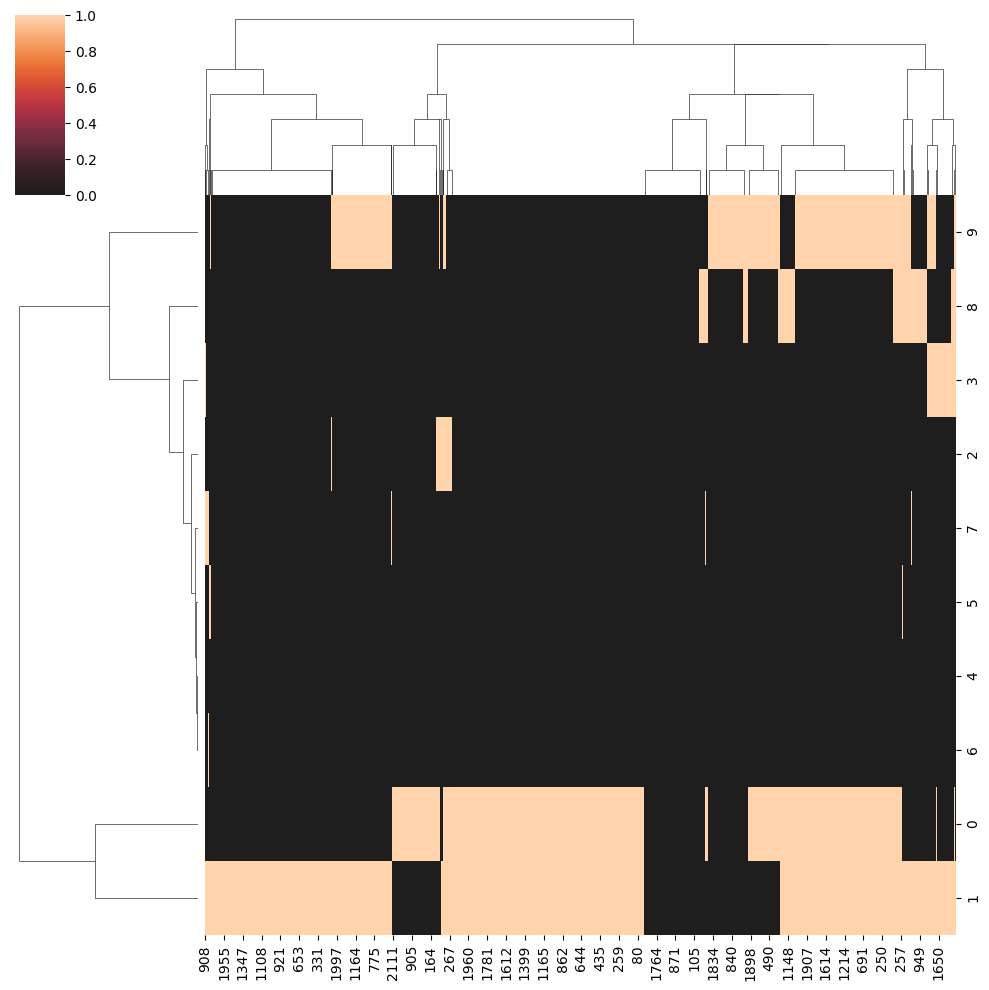

In [24]:
import seaborn as sns

sns.clustermap(
    (torch.clamp(dict(pyro.get_param_store())["u_loc"], -3, 3).cpu().detach() > 0.5),
    method="complete",
    metric="cityblock",
    center=0,
)

In [34]:
import numpy as np
import pandas as pd

features = pd.DataFrame(
    dict(pyro.get_param_store())["u_loc"].cpu().detach().numpy(), 
).T


weights = pd.DataFrame(
    (dict(pyro.get_param_store())["W_loc"]).cpu().detach().numpy(), 
    columns=adata.var_names[(adata.X > 0).mean(axis=0) > 0.05]
).T.sort_values(0, ascending=False)

In [63]:
for i in features.columns:
    adata.obs[f"class_{i}"] = ((1 / (1 + np.exp(-features[i]))) > 0.5).astype(int).tolist()
    adata.obs[f"feature_{i}"] = np.clip((features[i]).astype(float).tolist(), -1, 1)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

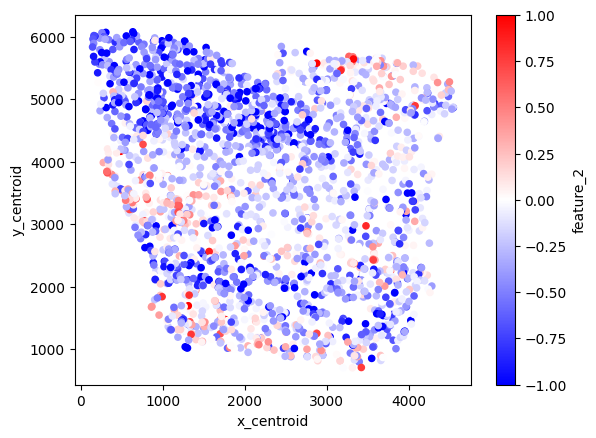

In [65]:
adata.obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="feature_2",
    cmap="bwr"
)

In [69]:
pd.DataFrame(
    pyro.get_param_store()["W_loc"].cpu().detach().numpy(),
    columns=adata[:, (adata.X > 0).mean(axis=0) > 0.05].var_names
).T.sort_values(by=2, ascending=False)

,0,1,2,3,4,5,6,7,8,9
GPNMB,-0.056857,0.143217,1.770200,-1.159541,0.442422,-0.191990,-0.104285,-0.111215,-0.101646,-0.175511
CD163,-0.075347,0.047742,1.461205,-0.725125,0.569856,-0.160950,-0.003794,-0.103358,-0.009619,-0.115140
TGFBI,-0.038772,0.105924,1.298183,-0.682190,0.464373,-0.079291,0.071371,-0.077457,0.000179,-0.046532
CTSD,-0.084707,-0.032588,1.164862,-0.664099,0.636745,0.014124,-0.009814,0.003705,0.034150,0.028966
CD83,0.050316,-0.180255,1.135533,-0.937978,-0.029794,-0.089245,-0.242954,-0.222716,-0.223729,-0.364138
...,...,...,...,...,...,...,...,...,...,...
ERMN,-0.222887,0.152639,-0.477997,0.282819,-0.552559,0.070099,0.006270,-0.052112,-0.059387,-0.101010
MEGF10,-0.060954,-0.326082,-0.502009,-0.423740,-0.557545,-0.047854,-0.140582,-0.226615,-0.242037,-0.311941
SAMD5,-0.421189,0.320515,-0.513199,0.309434,-0.626153,0.085789,-0.111519,-0.143274,-0.199894,-0.224659
IGFBP5,-0.199319,0.031787,-0.513683,0.168733,-0.608774,-0.077282,-0.083268,-0.035197,-0.074793,-0.123564


/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='class_2', ylabel='log_lipid_droplet_area'>

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 72.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/seaborn/categorical.py:3399: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


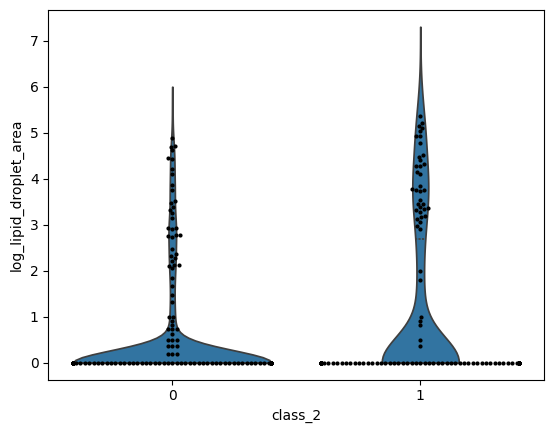

In [60]:
# adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])

i = 2
sns.violinplot(
    data = adata[adata.obs["spatial_groups_2960"].eq("Grey")].obs,
    x=f"class_{i}",
    y="log_lipid_droplet_area",
    cut=0,
    inner="quart",
    density_norm = "area"
)

sns.swarmplot(
    data = adata[adata.obs["spatial_groups_2960"].eq("Grey")].obs.sample(500),
    x=f"class_{i}",
    y="log_lipid_droplet_area",
    s=3,
    c="k"
)